In [12]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import figure
%matplotlib inline

import scipy as sp
from scipy import sparse
from scipy.fft import fft, ifft
from scipy.linalg import dft
from scipy.signal import find_peaks

from scipy.interpolate import interp1d

%load_ext sql
%sql sqlite:///Event.sqlite

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


The database is impoted and converted to a pandas dataframe, much better for data analysis in python and also better for exporting the data to numpy

In [5]:
cnx = sqlite3.connect(r'Event.sqlite')

# create the dataframe from a query
df = pd.read_sql_query("SELECT * FROM Event", cnx)

df.Origin == 'PyMeeus'
df.drop_duplicates()

,ID,DateTimeEventTT,Satellite,Type1,Type2,Type3,Origin,DateTimeAdded
0,1,2020-01-01 15:17:59,1,OM,D,EXT,Thuillot,2020-12-13 12:52:55
1,2,2020-01-01 15:21:38,1,OM,D,INT,Thuillot,2020-12-13 12:52:55
2,3,2020-01-01 15:23:21,1,PA,D,EXT,Thuillot,2020-12-13 12:52:55
3,4,2020-01-01 15:27:01,1,PA,D,INT,Thuillot,2020-12-13 12:52:55
4,5,2020-01-01 17:32:48,1,OM,F,INT,Thuillot,2020-12-13 12:52:55
...,...,...,...,...,...,...,...,...
661691,715840,2016-12-31 14:17:00,2,PA,D,INT,Thuillot,2021-04-28 11:36:37
661692,715841,2016-12-31 14:18:53,2,OM,F,INT,Thuillot,2021-04-28 11:36:37
661693,715842,2016-12-31 14:23:15,2,OM,F,EXT,Thuillot,2021-04-28 11:36:37
661694,715843,2016-12-31 16:37:23,2,PA,F,INT,Thuillot,2021-04-28 11:36:37


In [6]:
sql_cmd = """

WITH

PyMeeus AS
(
SELECT DateTimeEventTT, Satellite || Type1 || Type2 || Type3 AS Type, DateTimeEventTT, 
Satellite, Type1, Type2, Type3
FROM Event
WHERE ((Origin="PyMeeus") 
AND (Satellite == 1)  
AND (Type1 = "EC")
AND (Type2 = "D") 
AND (Type3 = "INT")
)),

Thuillot AS
(
SELECT DateTimeEventTT, Satellite || Type1 || Type2 || Type3 AS Type, DateTimeEventTT
FROM Event
WHERE ((Origin="Thuillot") 
AND (Satellite == 1)  
AND (Type1 = "EC")
AND (Type2 = "D") 
AND (Type3 = "INT")
))


SELECT p.DateTimeEventTT, p.Satellite, p.Type1, p.Type2, p.Type3, 
strftime('%s', p.DateTimeEventTT) - strftime('%s', t.DateTimeEventTT) AS deltaTime, 
MIN( ABS( strftime('%s', p.DateTimeEventTT) - strftime('%s', t.DateTimeEventTT) )) AS minDeltaTime
FROM (PyMeeus p INNER JOIN Thuillot t
ON p.Type = t.Type)
GROUP BY p.DateTimeEventTT
HAVING minDeltaTime <= 3600

"""

df = pd.read_sql_query(sql_cmd, cnx)

# Eclipses

## IO

Text(0.5, 1.0, 'Variation in eclipse Time for satellite 1 - D')

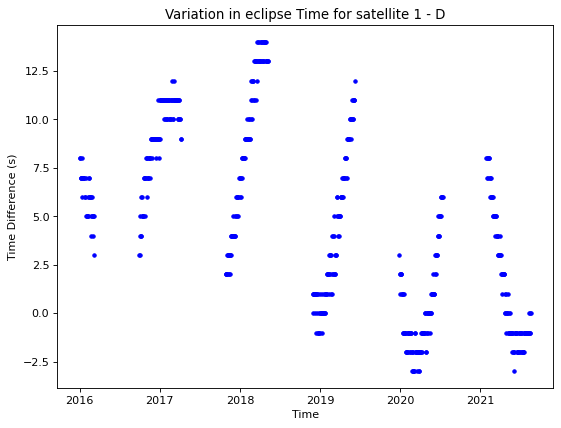

In [13]:
df_EC_INT_IO_INT= df[((df.Satellite == 1)&(df.Type1 == 'EC')&(df.Type2 == 'D')&(df.Type3 == 'INT'))]

df_EC_INT_IO_INT= df_EC_INT_IO_INT[[ 'DateTimeEventTT','deltaTime']]

figure(figsize=(8, 6), dpi=80)

dates_int = matplotlib.dates.date2num(df_EC_INT_IO_INT['DateTimeEventTT'].to_numpy())
matplotlib.pyplot.plot_date(dates_int, df_EC_INT_IO_INT['deltaTime'].to_numpy(), 'b.')

plt.ylabel('Time Difference (s)')
plt.xlabel('Time')
plt.title('Variation in eclipse Time for satellite 1 - D')

now it becomes necessaire to identify the portions of the s(t) function which is multiplied with the underlaying one in the time domain, in order to filter the effects of it out of the spectrum

In [14]:
datetime_array = df_EC_INT_IO_INT['DateTimeEventTT'].to_numpy()

df_unix_sec = pd.to_datetime(df_EC_INT_IO_INT['DateTimeEventTT']).astype(int)/ 10**9

first_sampling_time = df_unix_sec[0]

relative_sampling_time = df_unix_sec - first_sampling_time

#now we must find samples that are more than three days apart, usually the orbital period is somewhat like 6 days, so everything is ok

samples_diff_vec = np.zeros(len(relative_sampling_time)-1)

for i in range (len(relative_sampling_time)-1):

    samples_diff_vec[i] = relative_sampling_time[i+1] - relative_sampling_time[i]

    
#print(samples_diff_vec)

hot_positions = samples_diff_vec > 160000*2

#print(hot_positions)

#identify positions limits for the s(t) function

s_limits = np.zeros(len(relative_sampling_time))


for i in range (len(hot_positions)):

    if(hot_positions[i]):
    
        s_limits[i] = relative_sampling_time[i]
        i = i+1
        s_limits[i] = relative_sampling_time[i]

#print(s_limits)

non_zero_indices = (np.nonzero(s_limits))[0]

s_t = np.zeros(int(max(relative_sampling_time)))

i = 0

while i in range(np.size(non_zero_indices)-1):
    
    l_index = non_zero_indices[i]
    print(l_index)
    tmp = i+1
    i = i+1
    r_index = non_zero_indices[tmp]
    i = i+1

    for e in range(int(relative_sampling_time[l_index]), int(relative_sampling_time[r_index])):
        s_t[e] = 1.0

s_t_sparse=sparse.csr_matrix(s_t)

[ 35  36 144 145 253 254 363 364 476 477]
35
36
5657556
23396389
---
144
145
39909512
57495582
---
253
254
74161487
91747693
---
363
364
108413767
125847202
---
476
477
142972483
160253240
---
87625301.0


Text(0.5, 1.0, 'Windowing Function (downsampled by factor 32)')

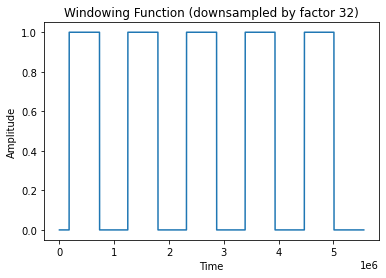

In [16]:
plt.plot(s_t[::32])

plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.title('Windowing Function (downsampled by factor 32)')

/home/vserra/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


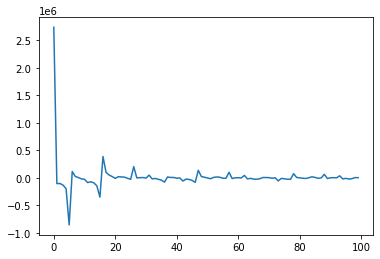

In [17]:
s_jump_spectrum = fft(s_t[::32])

plt.plot(s_jump_spectrum[0:10**2])

In [15]:
#now we have to generate the remianing data from the eclipse difference time data

eclipse_diff_data = np.zeros(int(max(relative_sampling_time)))


time_diff_data_sparse = df_EC_INT_IO_INT['deltaTime'].to_numpy()


for i in range(len(relative_sampling_time)-1):
    
    timestamp = int(relative_sampling_time[i])
    
    eclipse_diff_data[timestamp] = time_diff_data_sparse[i]

In [16]:
#plt.plot(eclipse_diff_data[::4], 'b.')

In [17]:
#perform the FFT

#the frequencie we want to be able to see are 1y and 10y. The overall sampling time is 5 years, menaning that we
#need to at least extend the number of samples --> this is only possible by performing a downsampling first
#otherwise the vector will be too much for the memory of the machine

#we are measuring everything in seconds, we don't really need that precision, let's switch to hours instead,
#this will reduce the size of the data to 50 thousands points

n_samples_per_bin = 3600
binned_vec_len = int((len(eclipse_diff_data)/n_samples_per_bin))

print("Length of new vector : " + str(binned_vec_len) + " from : " + str(len(eclipse_diff_data)))

zeropad_initial = len(eclipse_diff_data) - n_samples_per_bin * binned_vec_len

zeropad_vec = np.zeros(zeropad_initial)

np.append(eclipse_diff_data, zeropad_vec)

binned_eclipse_data_hours = np.zeros(binned_vec_len)

for i in range(binned_vec_len):

    binned_eclipse_data_hours[i] = np.sum(eclipse_diff_data[i*n_samples_per_bin: (i+1)*n_samples_per_bin])

#eclipse_data_downsampled = eclipse_diff_data[::10]

#print(str(len(eclipse_data_downsampled))  + "samples, is a 5 years period")

#len_zero_trailer = int(len(eclipse_data_downsampled) * 6 / 5);

#zero_trailer = np.zeros(len_zero_trailer)

#np.append(eclipse_data_downsampled, zero_trailer)

#plt.plot(eclipse_data_downsampled)

#s_spectrum = fft(eclipse_diff_data)


#print(s_spectrum)

Length of new vector : 49356 from : 177685007


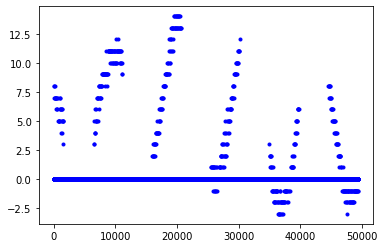

In [18]:
plt.plot(binned_eclipse_data_hours, 'b.')

In [19]:
s_spectrum = fft(binned_eclipse_data_hours)

/home/vserra/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


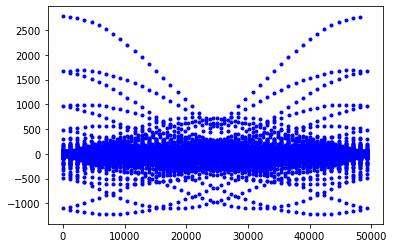

In [20]:
plt.plot(s_spectrum[:], 'b.')

In [21]:
#this is not a particularry good result, there are too many variables variating the spectrum, 
#hence too many harmonics
#we should filter it before we proceed

In [22]:
#let's begin with an interpolation, a simple cubic one

hours_linspace = np.linspace(0, len(binned_eclipse_data_hours)-1, len(binned_eclipse_data_hours))

idx = np.nonzero(binned_eclipse_data_hours)
interp = interp1d(hours_linspace[idx],binned_eclipse_data_hours[idx], kind = 'linear', fill_value="extrapolate")

print(interp)

eclipse_data_interp = interp(hours_linspace[:])

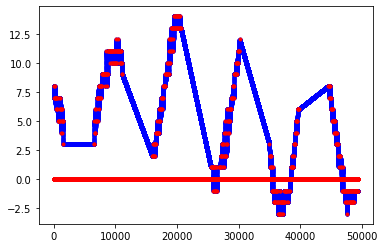

In [23]:
plt.plot(eclipse_data_interp, 'b.')
plt.plot(binned_eclipse_data_hours, 'r.')

In [24]:
#zero pad for higher resolutioin
zero_pad = np.zeros(10**7)
s_interp = fft(np.append(eclipse_data_interp, zero_pad))

/home/vserra/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


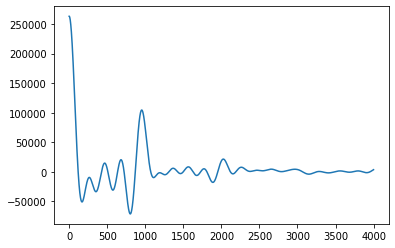

In [25]:
plt.plot(s_interp[0:4*10**2*10**1])

In [26]:
peaks, _ = find_peaks(np.abs(s_interp[:]), height=10**4)


print(peaks)

[     312      541      923     1199     1406     1615     1886     2025
 10047331 10047470 10047741 10047950 10048157 10048433 10048815 10049044]


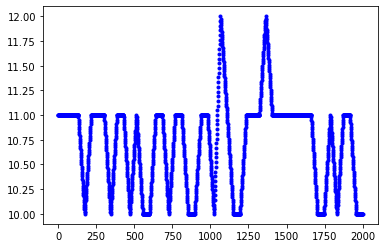

In [27]:
plt.plot(eclipse_data_interp[9000:11000], 'b.')

/home/vserra/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


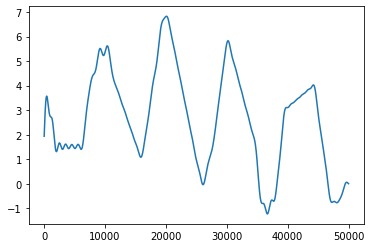

In [28]:
plt.plot(ifft(np.append(s_interp[0:10**4], zero_pad))[0:50*10**3])



In [29]:
np.append(s_t, zeropad_vec)

s_t_hrs = np.zeros(binned_vec_len)

print(binned_vec_len)

for i in range(binned_vec_len):

    s_t_hrs[i] = np.mean(s_t[i*n_samples_per_bin: (i+1)*n_samples_per_bin])

49356


49356
49356


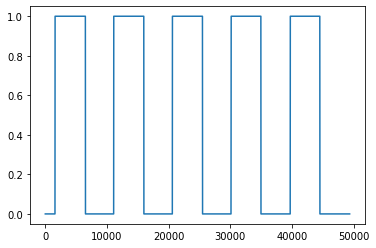

In [30]:
plt.plot(s_t_hrs)

print(len(s_t_hrs))

print(len(eclipse_data_interp))

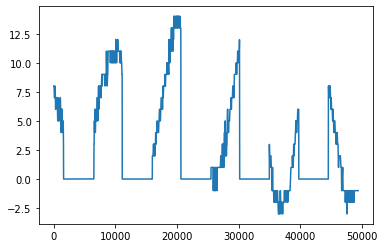

In [31]:
cleaned_array = eclipse_data_interp * (1-s_t_hrs)

plt.plot(cleaned_array)

s_cleaned = fft(np.append(cleaned_array, zero_pad))

/home/vserra/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


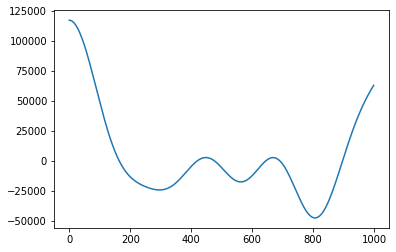

In [32]:
plt.plot(s_cleaned[0:10**3])

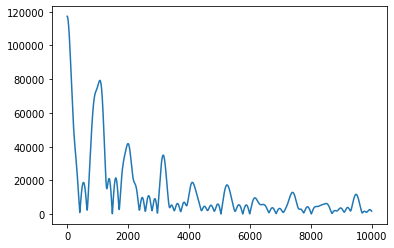

In [33]:
plt.plot(abs(s_cleaned[0:10**4]))

In [34]:
peaks, _ = find_peaks(np.abs(s_cleaned[:]), height=10**4)


print(peaks)

[     535     1075     1376     1597     1999     2677     3155     4113
     5252     7404     9491 10039865 10041952 10044104 10045243 10046201
 10046679 10047357 10047759 10047980 10048281 10048821]


In [35]:
#filter out the HF components resulting from the effect of rounding off to 1 sec

49356


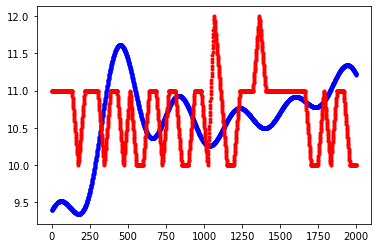

In [36]:
from scipy import signal


sos = signal.cheby1(10, 0.001, 0.005, 'low', analog=False, output = 'sos')

filtered = signal.sosfilt(sos, eclipse_data_interp*(1-s_t_hrs))

print(len(eclipse_data_interp))

plt.plot(filtered[9000:11000], 'b.')
plt.plot(eclipse_data_interp[9000:11000], 'r.')

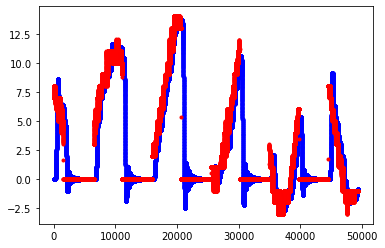

In [37]:
plt.plot(filtered[:], 'b.')
plt.plot(cleaned_array[:], 'r.')

/home/vserra/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/vserra/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


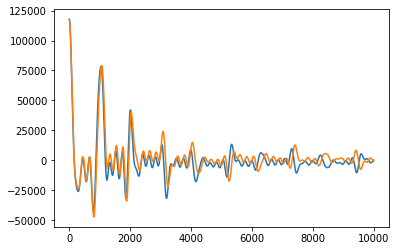

In [38]:
s_cleaned_cheby = fft(np.append(filtered, zero_pad))

plt.plot(s_cleaned_cheby[0:10**4])
plt.plot(s_cleaned[0:10**4])

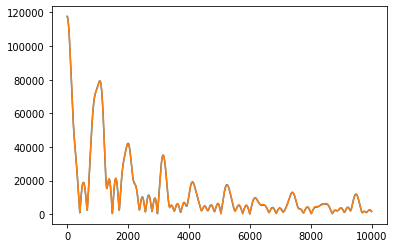

In [39]:
plt.plot(np.abs(s_cleaned_cheby[0:10**4]))
plt.plot(np.abs(s_cleaned[0:10**4]))

In [40]:
fft_s_t_upsample = fft(np.append(1-s_t_hrs , zero_pad)) 

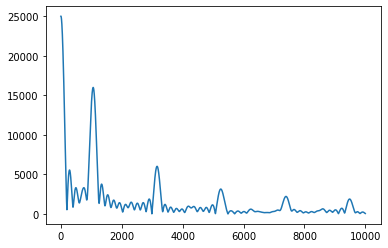

In [41]:


plt.plot(np.abs(fft_s_t_upsample)[0:10**4])

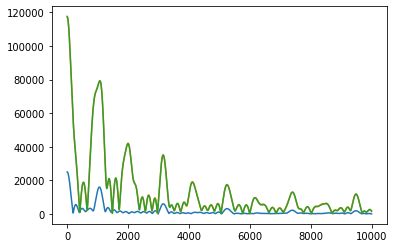

In [42]:
plt.plot(np.abs(fft_s_t_upsample)[0:10**4])
plt.plot(np.abs(s_cleaned_cheby[0:10**4]))
plt.plot(np.abs(s_cleaned[0:10**4]))

In [43]:
corr = np.correlate(s_cleaned_cheby, fft_s_t_upsample[0:10**4])


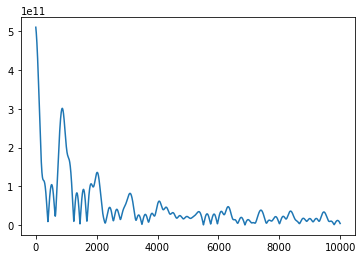

In [44]:
plt.plot(np.abs(corr[0:10**4]))

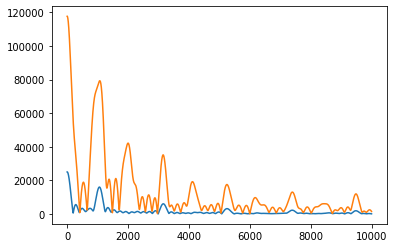

In [45]:
plt.plot(np.abs(fft_s_t_upsample)[0:10**4])
plt.plot(np.abs(s_cleaned_cheby[0:10**4]))

Length of new vector : 2056 from : 177685007


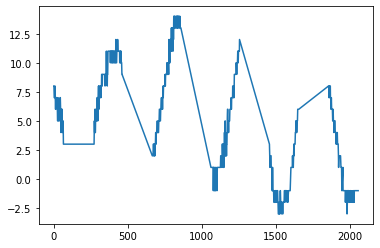

In [46]:
n_samples_per_bin = 3600*24
binned_vec_len = int((len(eclipse_diff_data)/n_samples_per_bin))

print("Length of new vector : " + str(binned_vec_len) + " from : " + str(len(eclipse_diff_data)))

zeropad_initial = len(eclipse_diff_data) - n_samples_per_bin * binned_vec_len

zeropad_vec = np.zeros(zeropad_initial)

np.append(eclipse_diff_data, zeropad_vec)

binned_eclipse_data_days = np.zeros(binned_vec_len)

for i in range(binned_vec_len):

    binned_eclipse_data_days[i] = np.sum(eclipse_diff_data[i*n_samples_per_bin: (i+1)*n_samples_per_bin])
    

days_linspace = np.linspace(0, len(binned_eclipse_data_days)-1, len(binned_eclipse_data_days))

idx = np.nonzero(binned_eclipse_data_days)
interp = interp1d(hours_linspace[idx],binned_eclipse_data_days[idx], kind = 'linear', fill_value="extrapolate")

print(interp)

eclipse_data_interp = interp(days_linspace[:])

plt.plot(eclipse_data_interp)

In [47]:
s_t_days = np.zeros(binned_vec_len)

print(binned_vec_len)

for i in range(binned_vec_len):

    s_t_days[i] = np.mean(s_t[i*n_samples_per_bin: (i+1)*n_samples_per_bin])

2056


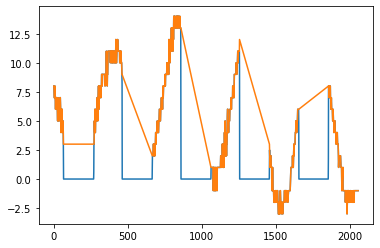

In [48]:
plt.plot(eclipse_data_interp*(1-s_t_days))
plt.plot(eclipse_data_interp)

[]

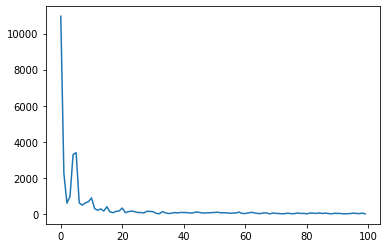

In [49]:
plt.plot(abs(fft(eclipse_data_interp)[0:100]))

plt.plot()

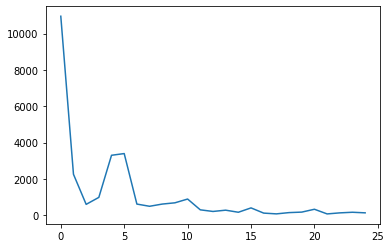

In [50]:
#plt.plot(np.abs(np.fft(s_t_days)[0:25]))
plt.plot(np.abs(fft(eclipse_data_interp)[0:25]))#plt.plot(np.abs(fft(eclipse_data_interp)[0:25]))#

/home/vserra/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


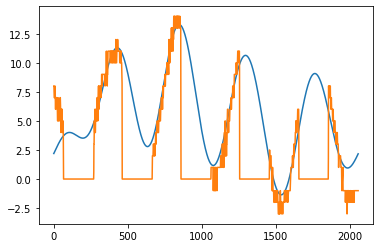

In [51]:
# try to build back the signal with the first 5 harmonics

signal_back = np.fft.ifft(fft(eclipse_data_interp)[0:7], 2056)#*(1-s_t_days)

plt.plot(2*signal_back-5)
plt.plot(eclipse_data_interp*(1-s_t_days))

In [52]:
print(peaks[0: int(len(peaks)/2)])

[ 535 1075 1376 1597 1999 2677 3155 4113 5252 7404 9491]


In [53]:
#now let's comnpute the spectrum of the signal in days with a super-resolution

#at first we need to create more samples inbetween the values
#since we are expecting a periodicity of 11 years and of 1 year overlapped, they should not end up in the first
#frequency bin
#this way we are kind of inserting a lot more data-points in the curve and shifting the frequencies to the 

In [54]:

from scipy.optimize import curve_fit

def func(time, f_1, phi_1, amplitude_1, f_2, phi_2, amplitude_2, offset):

    return offset + amplitude_1*np.sin(f_1*2*np.pi*time/365 + phi_1) + amplitude_2*np.sin(f_2*2*np.pi*time/365 + phi_2)

In [55]:
print(np.size(s_t_days))


mask = (1-s_t_days)

print(np.size(s_t_days))

mask = np.array(mask, dtype = 'bool')

print(mask)

values_w_nan = np.zeros(len(eclipse_data_interp))

values_w_nan[(1-s_t_days)==0] = np.nan
values_w_nan[(1-s_t_days)!=0] = eclipse_data_interp[(1-s_t_days)!=0]

popt, pcov = curve_fit(func, days_linspace[mask], eclipse_data_interp[mask], maxfev=10**4, 
                       bounds=([0,0,0,0,0,0,-7],[2, 2*np.pi, 100,0.2,2*np.pi,100,+10]), 
                      )#sigma = (1-s_t_days)+0.00001)


print(*popt)


2056
2056
[ True  True  True ...  True  True  True]
0.7941808553206046 2.514010015623716 6.53380402345921 0.08951155861936348 4.9313086516912034e-12 2.0347830483286495 4.290875822080906


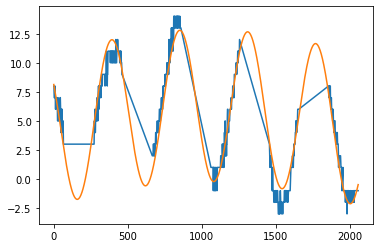

In [56]:
plt.plot(eclipse_data_interp[:])
plt.plot(func(days_linspace[:],*popt))

Text(0.5, 1.0, 'Variation in eclipse Time for satellite 2 - D')

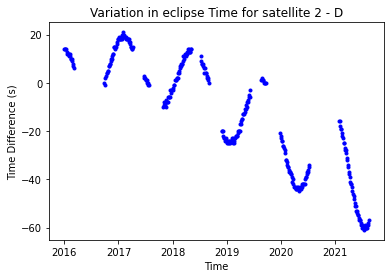

In [57]:
# create the dataframe from a query
df = pd.read_sql_query("SELECT * FROM Event", cnx)

sql_cmd = """

WITH

PyMeeus AS
(
SELECT DateTimeEventTT, Satellite || Type1 || Type2 || Type3 AS Type, DateTimeEventTT, 
Satellite, Type1, Type2, Type3
FROM Event
WHERE ((Origin="PyMeeus") 
AND (Satellite == 2)  
AND (Type1 = "EC")
AND (Type2 = "D") 
AND (Type3 = "INT")
)),

Thuillot AS
(
SELECT DateTimeEventTT, Satellite || Type1 || Type2 || Type3 AS Type, DateTimeEventTT
FROM Event
WHERE ((Origin="Thuillot") 
AND (Satellite == 2)  
AND (Type1 = "EC")
AND (Type2 = "D") 
AND (Type3 = "INT")
))


SELECT p.DateTimeEventTT, p.Satellite, p.Type1, p.Type2, p.Type3, 
strftime('%s', p.DateTimeEventTT) - strftime('%s', t.DateTimeEventTT) AS deltaTime, 
MIN( ABS( strftime('%s', p.DateTimeEventTT) - strftime('%s', t.DateTimeEventTT) )) AS minDeltaTime
FROM (PyMeeus p INNER JOIN Thuillot t
ON p.Type = t.Type)
GROUP BY p.DateTimeEventTT
HAVING minDeltaTime <= 3600

"""

df = pd.read_sql_query(sql_cmd, cnx)

#now do the same for europa --> load the data

df_EC_INT_IO_INT= df[((df.Satellite == 2)&(df.Type1 == 'EC')&(df.Type2 == 'D')&(df.Type3 == 'INT'))]

df_EC_INT_IO_INT= df_EC_INT_IO_INT[[ 'DateTimeEventTT','deltaTime']]

dates_int = matplotlib.dates.date2num(df_EC_INT_IO_INT['DateTimeEventTT'].to_numpy())
matplotlib.pyplot.plot_date(dates_int, df_EC_INT_IO_INT['deltaTime'].to_numpy(), 'b.')

plt.ylabel('Time Difference (s)')
plt.xlabel('Time')
plt.title('Variation in eclipse Time for satellite 2 - D')

In [58]:
datetime_array = df_EC_INT_IO_INT['DateTimeEventTT'].to_numpy()

In [59]:
df_unix_sec = pd.to_datetime(df_EC_INT_IO_INT['DateTimeEventTT']).astype(int)/ 10**9

#print(df_unix_sec)

first_sampling_time = df_unix_sec[0]

relative_sampling_time = df_unix_sec - first_sampling_time

print(relative_sampling_time)

0              0.0
1         307011.0
2         614018.0
3         921028.0
4        1228031.0
          ...     
325    176252616.0
326    176559717.0
327    176866875.0
328    177173980.0
329    177481146.0
Name: DateTimeEventTT, Length: 330, dtype: float64


In [60]:
#now we must find samples that are more than three days apart, usually the orbital period is somewhat like 6 days, so everything is ok

samples_diff_vec = np.zeros(len(relative_sampling_time)-1)

for i in range (len(relative_sampling_time)-1):

    samples_diff_vec[i] = relative_sampling_time[i+1] - relative_sampling_time[i]

    
#print(samples_diff_vec)

hot_positions = samples_diff_vec > 160000*5

#print(hot_positions)

#identify positions limits for the s(t) function

s_limits = np.zeros(len(relative_sampling_time))


for i in range (len(hot_positions)):

    if(hot_positions[i]):
    
        s_limits[i] = relative_sampling_time[i]
        i = i+1
        s_limits[i] = relative_sampling_time[i]

#print(s_limits)

non_zero_indices = (np.nonzero(s_limits))[0]


print(non_zero_indices)

s_t = np.zeros(int(max(relative_sampling_time)))

i = 0

while i in range(np.size(non_zero_indices)-1):
    
    l_index = non_zero_indices[i]
    print(l_index)
    tmp = i+1
    i = i+1
    r_index = non_zero_indices[tmp]
    i = i+1

    print(r_index)
    
    print(int(relative_sampling_time[l_index]))
    print(int(relative_sampling_time[r_index]))
    print('---')
    
    for e in range(int(relative_sampling_time[l_index]), int(relative_sampling_time[r_index])):
        s_t[e] = 1.0
        #print(int(relative_sampling_time[l_index]))
        
        

#print(s_t)
 
print(np.sum(s_t))

s_t_sparse=sparse.csr_matrix(s_t)
    

[ 18  19  73  74  83  84 136 137 152 153 207 208 216 217 272 273]
18
19
5526091
23335739
---
73
74
39916935
46364566
---
83
84
49127936
57725635
---
136
137
74000324
79527172
---
152
153
84132746
91808690
---
207
208
108390369
114838976
---
216
217
117295448
125892490
---
272
273
142781193
160285082
---
78607308.0


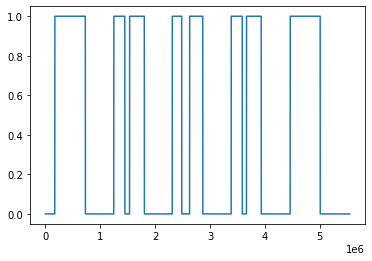

In [61]:
plt.plot(s_t[::32])

In [62]:
s_jump_spectrum = fft(s_t[::32])


print(s_jump_spectrum)

[2456477.            -0.j           87575.65835511+19139.32205821j
 -115371.36925308-58976.38417391j ... -120777.0985915 +96141.88042625j
 -115371.36925308+58976.38417391j   87575.65835511-19139.32205821j]


/home/vserra/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


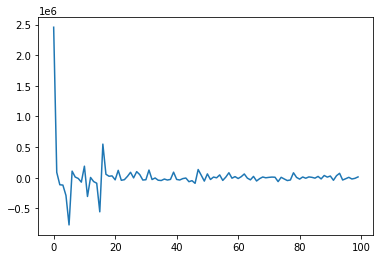

In [63]:
plt.plot(s_jump_spectrum[0:10**2])

In [64]:
#now we have to generate the remianing data from the eclipse difference time data

eclipse_diff_data = np.zeros(int(max(relative_sampling_time)))


time_diff_data_sparse = df_EC_INT_IO_INT['deltaTime'].to_numpy()


for i in range(len(relative_sampling_time)-1):
    
    timestamp = int(relative_sampling_time[i])
    
    eclipse_diff_data[timestamp] = time_diff_data_sparse[i]

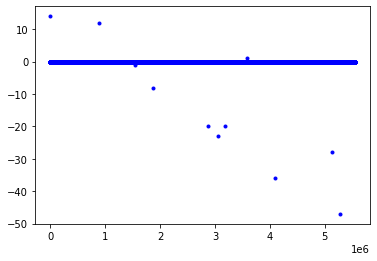

In [65]:
plt.plot(eclipse_diff_data[::32], 'b.')

In [66]:
#perform the FFT

#the frequencie we want to be able to see are 1y and 10y. The overall sampling time is 5 years, menaning that we
#need to at least extend the number of samples --> this is only possible by performing a downsampling first
#otherwise the vector will be too much for the memory of the machine

#we are measuring everything in seconds, we don't really need that precision, let's switch to hours instead,
#this will reduce the size of the data to 50 thousands points

n_samples_per_bin = 3600
binned_vec_len = int((len(eclipse_diff_data)/n_samples_per_bin))

print("Length of new vector : " + str(binned_vec_len) + " from : " + str(len(eclipse_diff_data)))

zeropad_initial = len(eclipse_diff_data) - n_samples_per_bin * binned_vec_len

zeropad_vec = np.zeros(zeropad_initial)

np.append(eclipse_diff_data, zeropad_vec)

binned_eclipse_data_hours = np.zeros(binned_vec_len)

for i in range(binned_vec_len):

    binned_eclipse_data_hours[i] = np.sum(eclipse_diff_data[i*n_samples_per_bin: (i+1)*n_samples_per_bin])

#eclipse_data_downsampled = eclipse_diff_data[::10]

#print(str(len(eclipse_data_downsampled))  + "samples, is a 5 years period")

#len_zero_trailer = int(len(eclipse_data_downsampled) * 6 / 5);

#zero_trailer = np.zeros(len_zero_trailer)

#np.append(eclipse_data_downsampled, zero_trailer)

#plt.plot(eclipse_data_downsampled)

#s_spectrum = fft(eclipse_diff_data)


#print(s_spectrum)

Length of new vector : 49300 from : 177481146


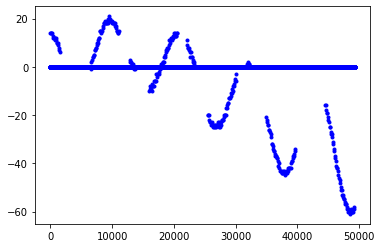

In [67]:
plt.plot(binned_eclipse_data_hours, 'b.')

In [68]:
s_spectrum = fft(binned_eclipse_data_hours)

/home/vserra/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


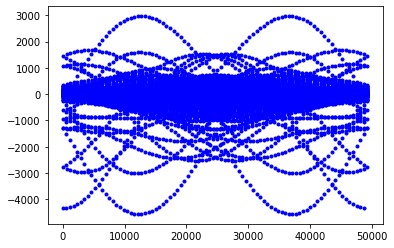

In [69]:
plt.plot(s_spectrum[:], 'b.')

In [70]:
#this is not a particularry good result, there are too many variables variating the spectrum, 
#hence too many harmonics
#we should filter it before we proceed

In [71]:
#let's begin with an interpolation, a simple cubic one

hours_linspace = np.linspace(0, len(binned_eclipse_data_hours)-1, len(binned_eclipse_data_hours))

idx = np.nonzero(binned_eclipse_data_hours)
interp = interp1d(hours_linspace[idx],binned_eclipse_data_hours[idx], kind = 'linear', fill_value="extrapolate")

print(interp)

eclipse_data_interp = interp(hours_linspace[:])

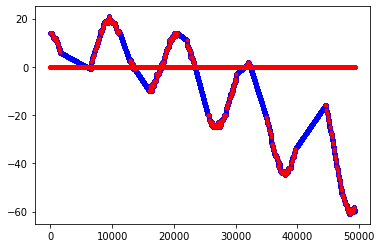

In [72]:
plt.plot(eclipse_data_interp, 'b.')
plt.plot(binned_eclipse_data_hours, 'r.')

In [73]:
#zero pad for higher resolutioin
zero_pad = np.zeros(10**7)
s_interp = fft(np.append(eclipse_data_interp, zero_pad))

/home/vserra/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


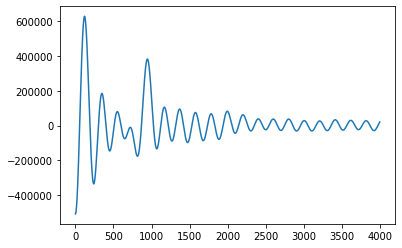

In [74]:
plt.plot(s_interp[0:4*10**2*10**1])

In [75]:
peaks, _ = find_peaks(np.abs(s_interp[:]), height=10**4)


print(peaks)

[     119      385      606      937     1209     1422     1641     1969
     2219     2433     2637     2847     3060     3263     3450     3657
     3871     4064     4282     4489     4693     4901     5100     5292
     5502     5710     5907     6125     6327     6534     6737     6917
     7125     7331     7544     7746     7952     8149     8345     8546
     8753     8962     9169     9371     9572     9773     9974    10185
    10386    10591    10806    11018    11605    11819    12040    13050
 10036250 10037260 10037481 10037695 10038282 10038494 10038709 10038914
 10039115 10039326 10039527 10039728 10039929 10040131 10040338 10040547
 10040754 10040955 10041151 10041348 10041554 10041756 10041969 10042175
 10042383 10042563 10042766 10042973 10043175 10043393 10043590 10043798
 10044008 10044200 10044399 10044607 10044811 10045018 10045236 10045429
 10045643 10045850 10046037 10046240 10046453 10046663 10046867 10047081
 10047331 10047659 10047878 10048091 10048363 10048

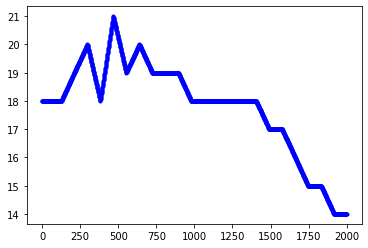

In [76]:
plt.plot(eclipse_data_interp[9000:11000], 'b.')

/home/vserra/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


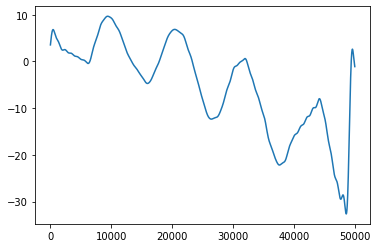

In [77]:
plt.plot(ifft(np.append(s_interp[0:10**4], zero_pad))[0:50*10**3])



In [78]:
np.append(s_t, zeropad_vec)

s_t_hrs = np.zeros(binned_vec_len)

print(binned_vec_len)

for i in range(binned_vec_len):

    s_t_hrs[i] = np.mean(s_t[i*n_samples_per_bin: (i+1)*n_samples_per_bin])

49300


49300
49300


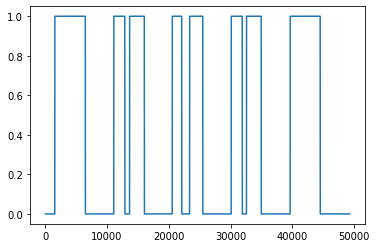

In [79]:
plt.plot(s_t_hrs)

print(len(s_t_hrs))

print(len(eclipse_data_interp))

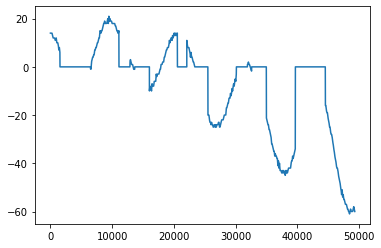

In [80]:
cleaned_array = eclipse_data_interp * (1-s_t_hrs)

plt.plot(cleaned_array)

s_cleaned = fft(np.append(cleaned_array, zero_pad))

/home/vserra/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


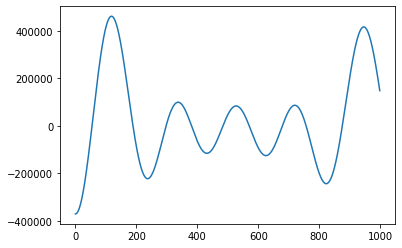

In [81]:
plt.plot(s_cleaned[0:10**3])

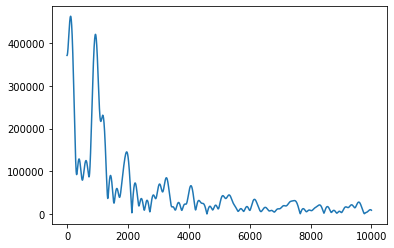

In [82]:
plt.plot(abs(s_cleaned[0:10**4]))

In [83]:
peaks, _ = find_peaks(np.abs(s_cleaned[:]), height=10**4)


print(peaks)

[     117      394      623      934     1173     1428     1636     1959
     2236     2440     2629     2837     3040     3263     3476     3664
     3873     4070     4329     4694     4883     5118     5323     5711
     5910     6157     6512     6945     7127     7470     7759     8295
     8554     9160     9348     9584     9963    10184    10392    10639
    10792    11413    11642    12469    13472    13801    14454    14634
    15491    15682    15906    16724    17727    17982    18789    22220
    24043    24299 10025001 10025257 10027080 10030511 10031318 10031573
 10032576 10033394 10033618 10033809 10034666 10034846 10035499 10035828
 10036831 10037658 10037887 10038508 10038661 10038908 10039116 10039337
 10039716 10039952 10040140 10040746 10041005 10041541 10041830 10042173
 10042355 10042788 10043143 10043390 10043589 10043977 10044182 10044417
 10044606 10044971 10045230 10045427 10045636 10045824 10046037 10046260
 10046463 10046671 10046860 10047064 10047341 10047

In [84]:
#filter out the HF components resulting from the effect of rounding off to 1 sec

49300


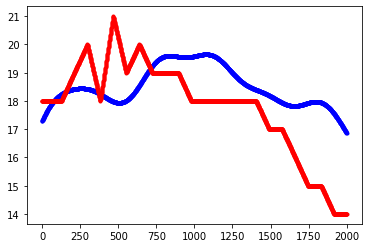

In [85]:
from scipy import signal


sos = signal.cheby1(10, 0.001, 0.005, 'low', analog=False, output = 'sos')

filtered = signal.sosfilt(sos, eclipse_data_interp*(1-s_t_hrs))

print(len(eclipse_data_interp))

plt.plot(filtered[9000:11000], 'b.')
plt.plot(eclipse_data_interp[9000:11000], 'r.')

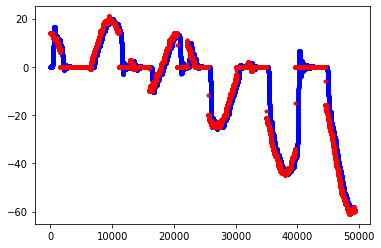

In [86]:
plt.plot(filtered[:], 'b.')
plt.plot(cleaned_array[:], 'r.')

/home/vserra/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/vserra/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


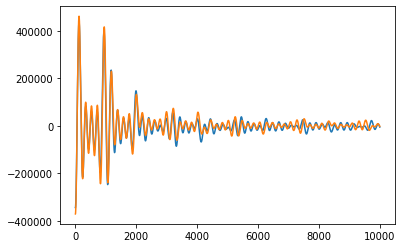

In [87]:
s_cleaned_cheby = fft(np.append(filtered, zero_pad))

plt.plot(s_cleaned_cheby[0:10**4])
plt.plot(s_cleaned[0:10**4])

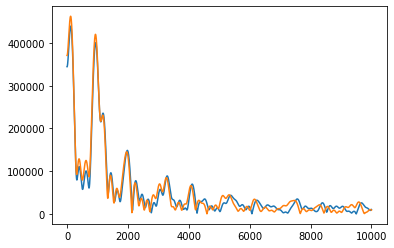

In [88]:
plt.plot(np.abs(s_cleaned_cheby[0:10**4]))
plt.plot(np.abs(s_cleaned[0:10**4]))

In [89]:
fft_s_t_upsample = fft(np.append(1-s_t_hrs , zero_pad)) 

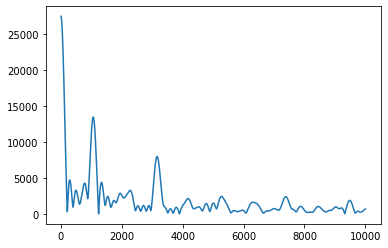

In [90]:


plt.plot(np.abs(fft_s_t_upsample)[0:10**4])

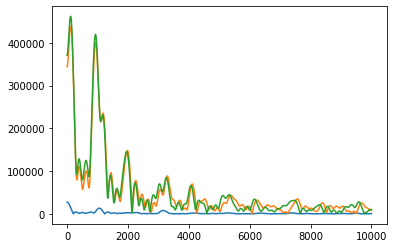

In [91]:
plt.plot(np.abs(fft_s_t_upsample)[0:10**4])
plt.plot(np.abs(s_cleaned_cheby[0:10**4]))
plt.plot(np.abs(s_cleaned[0:10**4]))

In [92]:
corr = np.correlate(s_cleaned_cheby, fft_s_t_upsample[0:10**4])


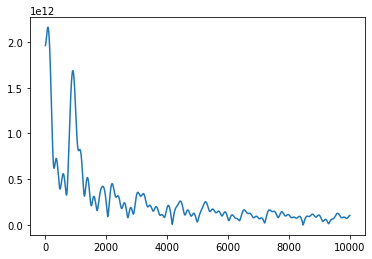

In [93]:
plt.plot(np.abs(corr[0:10**4]))

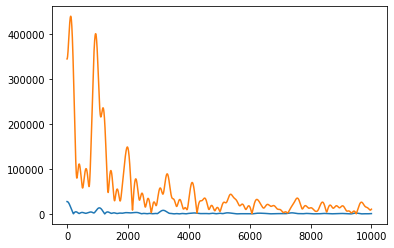

In [94]:
plt.plot(np.abs(fft_s_t_upsample)[0:10**4])
plt.plot(np.abs(s_cleaned_cheby[0:10**4]))

Length of new vector : 2054 from : 177481146


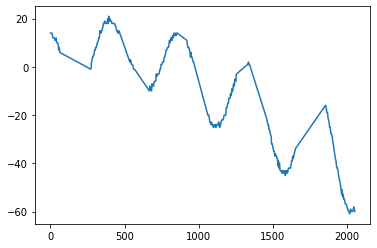

In [95]:
n_samples_per_bin = 3600*24
binned_vec_len = int((len(eclipse_diff_data)/n_samples_per_bin))

print("Length of new vector : " + str(binned_vec_len) + " from : " + str(len(eclipse_diff_data)))

zeropad_initial = len(eclipse_diff_data) - n_samples_per_bin * binned_vec_len

zeropad_vec = np.zeros(zeropad_initial)

np.append(eclipse_diff_data, zeropad_vec)

binned_eclipse_data_days = np.zeros(binned_vec_len)

for i in range(binned_vec_len):

    binned_eclipse_data_days[i] = np.sum(eclipse_diff_data[i*n_samples_per_bin: (i+1)*n_samples_per_bin])
    

days_linspace = np.linspace(0, len(binned_eclipse_data_days)-1, len(binned_eclipse_data_days))

idx = np.nonzero(binned_eclipse_data_days)
interp = interp1d(hours_linspace[idx],binned_eclipse_data_days[idx], kind = 'linear', fill_value="extrapolate")

print(interp)

eclipse_data_interp = interp(days_linspace[:])

plt.plot(eclipse_data_interp)

In [96]:
s_t_days = np.zeros(binned_vec_len)

print(binned_vec_len)

for i in range(binned_vec_len):

    s_t_days[i] = np.mean(s_t[i*n_samples_per_bin: (i+1)*n_samples_per_bin])

2054


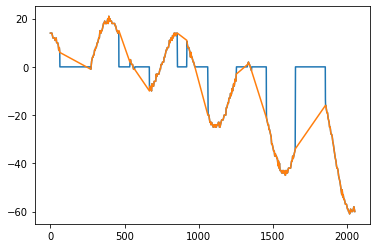

In [97]:
plt.plot(eclipse_data_interp*(1-s_t_days))
plt.plot(eclipse_data_interp)

[]

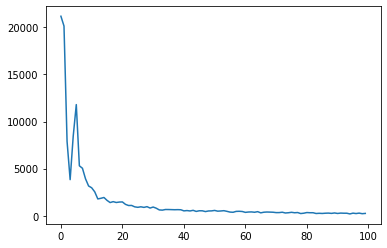

In [98]:
plt.plot(abs(fft(eclipse_data_interp)[0:100]))

plt.plot()

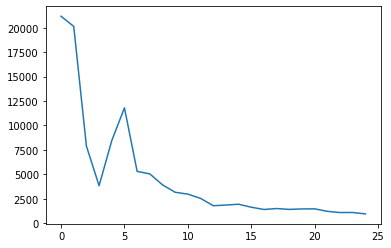

In [99]:
#plt.plot(np.abs(np.fft(s_t_days)[0:25]))
plt.plot(np.abs(fft(eclipse_data_interp)[0:25]))#plt.plot(np.abs(fft(eclipse_data_interp)[0:25]))#

/home/vserra/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


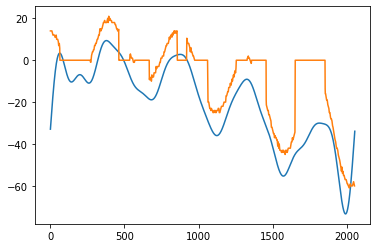

In [100]:
# try to build back the signal with the first 5 harmonics

signal_back = np.fft.ifft(fft(eclipse_data_interp)[0:15], 2056)#*(1-s_t_days)

plt.plot(2*signal_back)
plt.plot(eclipse_data_interp*(1-s_t_days))

In [101]:
print(peaks[0: int(len(peaks)/2)])

[  117   394   623   934  1173  1428  1636  1959  2236  2440  2629  2837
  3040  3263  3476  3664  3873  4070  4329  4694  4883  5118  5323  5711
  5910  6157  6512  6945  7127  7470  7759  8295  8554  9160  9348  9584
  9963 10184 10392 10639 10792 11413 11642 12469 13472 13801 14454 14634
 15491 15682 15906 16724 17727 17982 18789 22220 24043 24299]


In [102]:
#now let's comnpute the spectrum of the signal in days with a super-resolution

#at first we need to create more samples inbetween the values
#since we are expecting a periodicity of 11 years and of 1 year overlapped, they should not end up in the first
#frequency bin
#this way we are kind of inserting a lot more data-points in the curve and shifting the frequencies to the 

In [103]:

from scipy.optimize import curve_fit

def func(time, f_1, phi_1, amplitude_1, f_2, phi_2, amplitude_2, offset):

    return offset + amplitude_1*np.sin(f_1*2*np.pi*time/365 + phi_1) + amplitude_2*np.sin(f_2*2*np.pi*time/365 + phi_2)

In [104]:
print(np.size(s_t_days))


mask = (1-s_t_days)

print(np.size(s_t_days))

mask = np.array(mask, dtype = 'bool')

print(mask)

values_w_nan = np.zeros(len(eclipse_data_interp))

values_w_nan[(1-s_t_days)==0] = np.nan
values_w_nan[(1-s_t_days)!=0] = eclipse_data_interp[(1-s_t_days)!=0]

popt, pcov = curve_fit(func, days_linspace[mask], eclipse_data_interp[mask], maxfev=10**4, 
                       bounds=([0,0,0,0,0,0,-50],[1.5, 2*np.pi, 20,0.2,2*np.pi,25,+50]), 
                      )#sigma = (1-s_t_days)+0.00001)


print(*popt)


2054
2054
[ True  True  True ...  True  True  True]
0.7888581630936208 2.265398191700138 16.876928243401846 0.08874917408017953 0.9730553622473813 24.99999999999983 -19.593220115132105


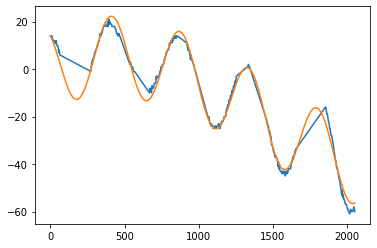

In [105]:
plt.plot(eclipse_data_interp[:])
plt.plot(func(days_linspace[:],*popt))

Text(0.5, 1.0, 'Variation in eclipse Time for satellite 2 - D')

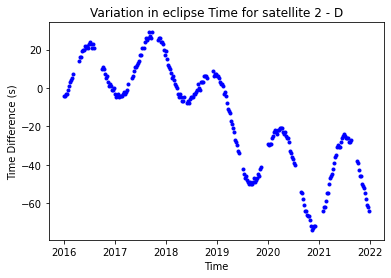

In [106]:
# create the dataframe from a query
df = pd.read_sql_query("SELECT * FROM Event", cnx)

sql_cmd = """

WITH

PyMeeus AS
(
SELECT DateTimeEventTT, Satellite || Type1 || Type2 || Type3 AS Type, DateTimeEventTT, 
Satellite, Type1, Type2, Type3
FROM Event
WHERE ((Origin="PyMeeus") 
AND (Satellite == 3)  
AND (Type1 = "EC")
AND (Type2 = "D") 
AND (Type3 = "INT")
)),

Thuillot AS
(
SELECT DateTimeEventTT, Satellite || Type1 || Type2 || Type3 AS Type, DateTimeEventTT
FROM Event
WHERE ((Origin="Thuillot") 
AND (Satellite == 3)  
AND (Type1 = "EC")
AND (Type2 = "D") 
AND (Type3 = "INT")
))


SELECT p.DateTimeEventTT, p.Satellite, p.Type1, p.Type2, p.Type3, 
strftime('%s', p.DateTimeEventTT) - strftime('%s', t.DateTimeEventTT) AS deltaTime, 
MIN( ABS( strftime('%s', p.DateTimeEventTT) - strftime('%s', t.DateTimeEventTT) )) AS minDeltaTime
FROM (PyMeeus p INNER JOIN Thuillot t
ON p.Type = t.Type)
GROUP BY p.DateTimeEventTT
HAVING minDeltaTime <= 3600

"""

df = pd.read_sql_query(sql_cmd, cnx)

#now do the same for europa --> load the data

df_EC_INT_IO_INT= df[((df.Satellite == 3)&(df.Type1 == 'EC')&(df.Type2 == 'D')&(df.Type3 == 'INT'))]

df_EC_INT_IO_INT= df_EC_INT_IO_INT[[ 'DateTimeEventTT','deltaTime']]

dates_int = matplotlib.dates.date2num(df_EC_INT_IO_INT['DateTimeEventTT'].to_numpy())
matplotlib.pyplot.plot_date(dates_int, df_EC_INT_IO_INT['deltaTime'].to_numpy(), 'b.')

plt.ylabel('Time Difference (s)')
plt.xlabel('Time')
plt.title('Variation in eclipse Time for satellite 2 - D')

In [107]:
datetime_array = df_EC_INT_IO_INT['DateTimeEventTT'].to_numpy()

In [108]:
df_unix_sec = pd.to_datetime(df_EC_INT_IO_INT['DateTimeEventTT']).astype(int)/ 10**9

#print(df_unix_sec)

first_sampling_time = df_unix_sec[0]

relative_sampling_time = df_unix_sec - first_sampling_time

print(relative_sampling_time)

0              0.0
1         619052.0
2        1238154.0
3        1857237.0
4        2476362.0
          ...     
247    186360661.0
248    186979986.0
249    187599314.0
250    188218612.0
251    188837907.0
Name: DateTimeEventTT, Length: 252, dtype: float64


In [109]:
#now we must find samples that are more than three days apart, usually the orbital period is somewhat like 6 days, so everything is ok

samples_diff_vec = np.zeros(len(relative_sampling_time)-1)

for i in range (len(relative_sampling_time)-1):

    samples_diff_vec[i] = relative_sampling_time[i+1] - relative_sampling_time[i]

    
#print(samples_diff_vec)

hot_positions = samples_diff_vec > 3600*24*10 #gaps > than 10 days

#print(hot_positions)

#identify positions limits for the s(t) function

s_limits = np.zeros(len(relative_sampling_time))


for i in range (len(hot_positions)):

    if(hot_positions[i]):
    
        s_limits[i] = relative_sampling_time[i]
        i = i+1
        s_limits[i] = relative_sampling_time[i]

#print(s_limits)

non_zero_indices = (np.nonzero(s_limits))[0]


print(non_zero_indices)

s_t = np.zeros(int(max(relative_sampling_time)))

i = 0

while i in range(np.size(non_zero_indices)-1):
    
    l_index = non_zero_indices[i]
    print(l_index)
    tmp = i+1
    i = i+1
    r_index = non_zero_indices[tmp]
    i = i+1

    print(r_index)
    
    print(int(relative_sampling_time[l_index]))
    print(int(relative_sampling_time[r_index]))
    print('---')
    
    for e in range(int(relative_sampling_time[l_index]), int(relative_sampling_time[r_index])):
        s_t[e] = 1.0
        #print(int(relative_sampling_time[l_index]))
        
        

#print(s_t)
 
print(np.sum(s_t))

s_t_sparse=sparse.csr_matrix(s_t)
    

[  9  10  25  26  52  53  63  64  72  73  99 100 120 121 147 148 166 167
 194 195 209 210 238 239]
9
10
5571859
9286736
---
25
26
18574374
23527402
---
52
53
39623303
42099915
---
63
64
48291683
49530106
---
72
73
54483454
58198195
---
99
100
74293831
76151222
---
120
121
88534180
92248792
---
147
148
108343877
110820321
---
166
167
121965195
126299221
---
194
195
143014985
146730024
---
209
210
155399291
160353179
---
238
239
177690571
181406121
---
40864631.0


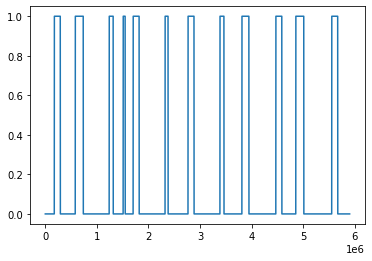

In [110]:
plt.plot(s_t[::32])

In [111]:
s_jump_spectrum = fft(s_t[::32])


print(s_jump_spectrum)

[1277018.            -0.j          108951.69260492+30533.37666692j
  -50989.9694383 -43289.47440081j ...  -19528.15938339+47489.87306155j
  -50989.9694383 +43289.47440081j  108951.69260492-30533.37666692j]


/home/vserra/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


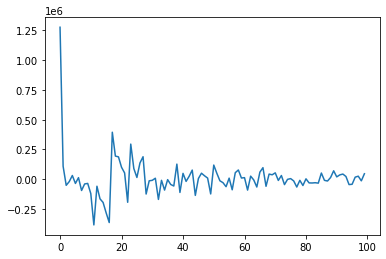

In [112]:
plt.plot(s_jump_spectrum[0:10**2])

In [113]:
#now we have to generate the remianing data from the eclipse difference time data

eclipse_diff_data = np.zeros(int(max(relative_sampling_time)))


time_diff_data_sparse = df_EC_INT_IO_INT['deltaTime'].to_numpy()


for i in range(len(relative_sampling_time)-1):
    
    timestamp = int(relative_sampling_time[i])
    
    eclipse_diff_data[timestamp] = time_diff_data_sparse[i]

In [114]:
#plt.plot(eclipse_diff_data[::4], 'b.')

In [115]:
#perform the FFT

#the frequencie we want to be able to see are 1y and 10y. The overall sampling time is 5 years, menaning that we
#need to at least extend the number of samples --> this is only possible by performing a downsampling first
#otherwise the vector will be too much for the memory of the machine

#we are measuring everything in seconds, we don't really need that precision, let's switch to hours instead,
#this will reduce the size of the data to 50 thousands points

n_samples_per_bin = 3600
binned_vec_len = int((len(eclipse_diff_data)/n_samples_per_bin))

print("Length of new vector : " + str(binned_vec_len) + " from : " + str(len(eclipse_diff_data)))

zeropad_initial = len(eclipse_diff_data) - n_samples_per_bin * binned_vec_len

zeropad_vec = np.zeros(zeropad_initial)

np.append(eclipse_diff_data, zeropad_vec)

binned_eclipse_data_hours = np.zeros(binned_vec_len)

for i in range(binned_vec_len):

    binned_eclipse_data_hours[i] = np.sum(eclipse_diff_data[i*n_samples_per_bin: (i+1)*n_samples_per_bin])

#eclipse_data_downsampled = eclipse_diff_data[::10]

#print(str(len(eclipse_data_downsampled))  + "samples, is a 5 years period")

#len_zero_trailer = int(len(eclipse_data_downsampled) * 6 / 5);

#zero_trailer = np.zeros(len_zero_trailer)

#np.append(eclipse_data_downsampled, zero_trailer)

#plt.plot(eclipse_data_downsampled)

#s_spectrum = fft(eclipse_diff_data)


#print(s_spectrum)

Length of new vector : 52454 from : 188837907


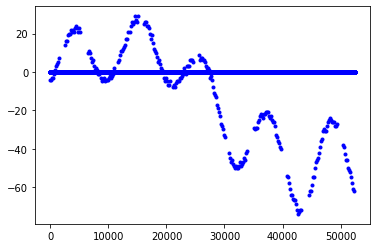

In [116]:
plt.plot(binned_eclipse_data_hours, 'b.')

In [117]:
s_spectrum = fft(binned_eclipse_data_hours)

/home/vserra/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


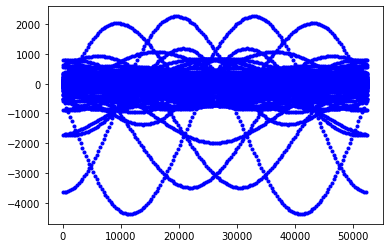

In [118]:
plt.plot(s_spectrum[:], 'b.')

In [119]:
#this is not a particularry good result, there are too many variables variating the spectrum, 
#hence too many harmonics
#we should filter it before we proceed

In [120]:
#let's begin with an interpolation, a simple cubic one

hours_linspace = np.linspace(0, len(binned_eclipse_data_hours)-1, len(binned_eclipse_data_hours))

idx = np.nonzero(binned_eclipse_data_hours)
interp = interp1d(hours_linspace[idx],binned_eclipse_data_hours[idx], kind = 'linear', fill_value="extrapolate")

print(interp)

eclipse_data_interp = interp(hours_linspace[:])

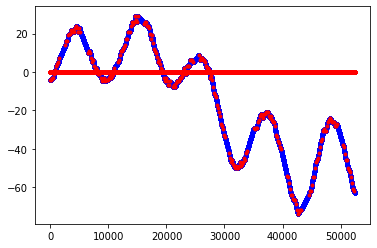

In [121]:
plt.plot(eclipse_data_interp, 'b.')
plt.plot(binned_eclipse_data_hours, 'r.')

In [122]:
#zero pad for higher resolutioin
zero_pad = np.zeros(10**7)
s_interp = fft(np.append(eclipse_data_interp, zero_pad))

/home/vserra/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


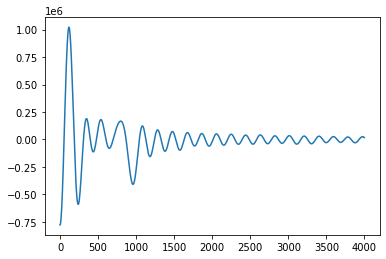

In [123]:
plt.plot(s_interp[0:4*10**2*10**1])

In [124]:
peaks, _ = find_peaks(np.abs(s_interp[:]), height=10**4)


print(peaks)

[     126      562      937     1196     1397     1596     1803     1989
     2188     2376     2573     2737     2939     3114     3327     3530
     3710     3908     4119     4330     4454     4684     4861     5045
     5265     5453     5638     5864     6050     6249     6431     6609
     6760     6988     7196     7416     7736     7944     8122     8372
     8504     8726     8930     9161     9472     9695     9907    10215
    10439    10666    10848    11403    12931    14618    16688 10035766
 10037836 10039523 10041051 10041606 10041788 10042015 10042239 10042547
 10042759 10042982 10043293 10043524 10043728 10043950 10044082 10044332
 10044510 10044718 10045038 10045258 10045466 10045694 10045845 10046023
 10046205 10046404 10046590 10046816 10047001 10047189 10047409 10047593
 10047770 10048000 10048124 10048335 10048546 10048744 10048924 10049127
 10049340 10049515 10049717 10049881 10050078 10050266 10050465 10050651
 10050858 10051057 10051258 10051517 10051892 10052

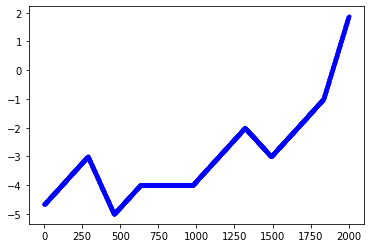

In [125]:
plt.plot(eclipse_data_interp[9000:11000], 'b.')

/home/vserra/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


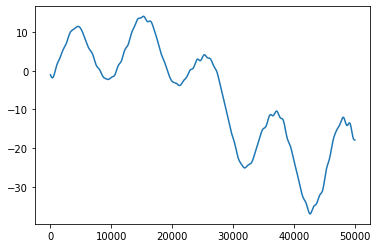

In [126]:
plt.plot(ifft(np.append(s_interp[0:10**4], zero_pad))[0:50*10**3])



In [127]:
np.append(s_t, zeropad_vec)

s_t_hrs = np.zeros(binned_vec_len)

print(binned_vec_len)

for i in range(binned_vec_len):

    s_t_hrs[i] = np.mean(s_t[i*n_samples_per_bin: (i+1)*n_samples_per_bin])

52454


52454
52454


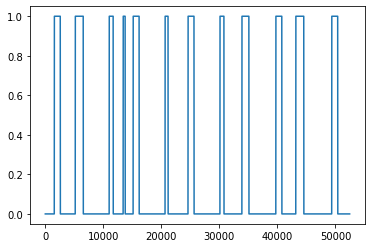

In [128]:
plt.plot(s_t_hrs)

print(len(s_t_hrs))

print(len(eclipse_data_interp))

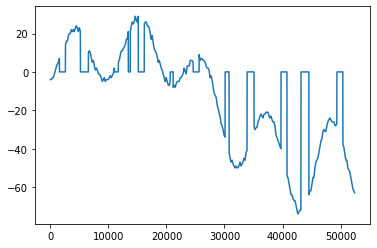

In [129]:
cleaned_array = eclipse_data_interp * (1-s_t_hrs)

plt.plot(cleaned_array)

s_cleaned = fft(np.append(cleaned_array, zero_pad))

/home/vserra/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


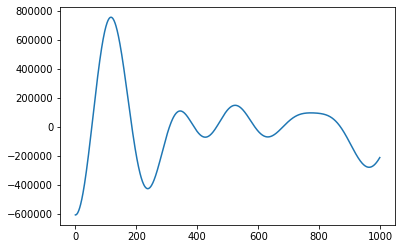

In [130]:
plt.plot(s_cleaned[0:10**3])

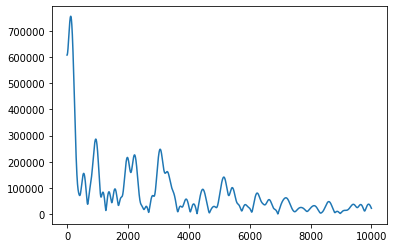

In [131]:
plt.plot(abs(s_cleaned[0:10**4]))

In [132]:
peaks, _ = find_peaks(np.abs(s_cleaned[:]), height=10**4)


print(peaks)

[     121      547      944     1179     1377     1575     1983     2217
     2603     2814     3059     3288     3725     3912     4159     4459
     4829     5150     5427     5856     6246     6636     7189     7684
     8116     8599     8875     9138     9406     9647     9907    10199
    10696    10924    11251    11665    11958    12245    12487    12721
    13056    13314    13577    14116    14354    14927    15470    15766
    16065    16332    16654    16886    17115    17369    17532    17783
    18147    18398    19194    19445    19736    20518    20743    21146
    21552    21988    22183    22817    23053    23602    23921    24269
    24589    25174    25769    26005    26240    26898    27116    31326
    32210    32441    32693    33283    34190    34530    35389    35634
    39003    40039    41059    42382    42684    44876    46489    46768
    47527    53301    55385    61517    63604  9988850  9990937  9997069
  9999153 10004927 10005686 10005965 10007578 10009

In [133]:
#filter out the HF components resulting from the effect of rounding off to 1 sec

52454


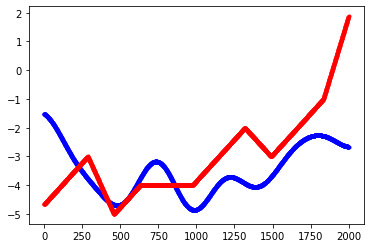

In [134]:
from scipy import signal


sos = signal.cheby1(10, 0.001, 0.005, 'low', analog=False, output = 'sos')

filtered = signal.sosfilt(sos, eclipse_data_interp*(1-s_t_hrs))

print(len(eclipse_data_interp))

plt.plot(filtered[9000:11000], 'b.')
plt.plot(eclipse_data_interp[9000:11000], 'r.')

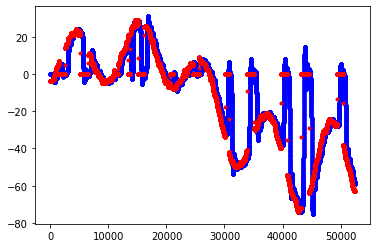

In [135]:
plt.plot(filtered[:], 'b.')
plt.plot(cleaned_array[:], 'r.')

/home/vserra/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/vserra/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


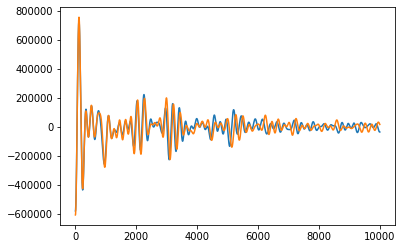

In [136]:
s_cleaned_cheby = fft(np.append(filtered, zero_pad))

plt.plot(s_cleaned_cheby[0:10**4])
plt.plot(s_cleaned[0:10**4])

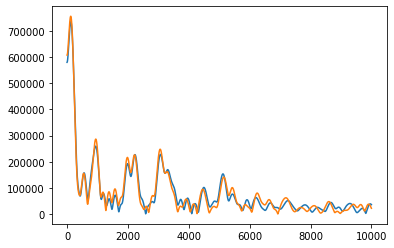

In [137]:
plt.plot(np.abs(s_cleaned_cheby[0:10**4]))
plt.plot(np.abs(s_cleaned[0:10**4]))

In [138]:
fft_s_t_upsample = fft(np.append(1-s_t_hrs , zero_pad)) 

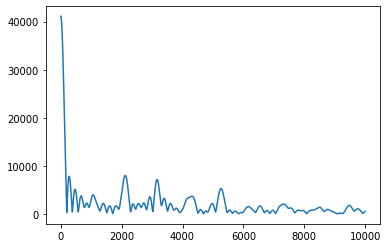

In [139]:


plt.plot(np.abs(fft_s_t_upsample)[0:10**4])

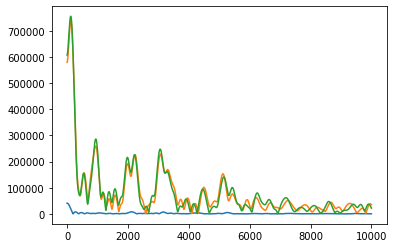

In [140]:
plt.plot(np.abs(fft_s_t_upsample)[0:10**4])
plt.plot(np.abs(s_cleaned_cheby[0:10**4]))
plt.plot(np.abs(s_cleaned[0:10**4]))

In [141]:
corr = np.correlate(s_cleaned_cheby, fft_s_t_upsample[0:10**4])


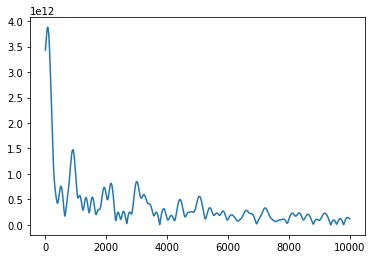

In [142]:
plt.plot(np.abs(corr[0:10**4]))

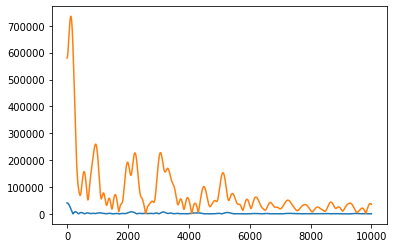

In [143]:
plt.plot(np.abs(fft_s_t_upsample)[0:10**4])
plt.plot(np.abs(s_cleaned_cheby[0:10**4]))

Length of new vector : 2185 from : 188837907


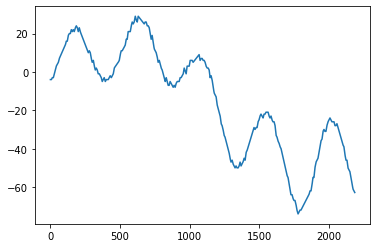

In [144]:
n_samples_per_bin = 3600*24
binned_vec_len = int((len(eclipse_diff_data)/n_samples_per_bin))

print("Length of new vector : " + str(binned_vec_len) + " from : " + str(len(eclipse_diff_data)))

zeropad_initial = len(eclipse_diff_data) - n_samples_per_bin * binned_vec_len

zeropad_vec = np.zeros(zeropad_initial)

np.append(eclipse_diff_data, zeropad_vec)

binned_eclipse_data_days = np.zeros(binned_vec_len)

for i in range(binned_vec_len):

    binned_eclipse_data_days[i] = np.sum(eclipse_diff_data[i*n_samples_per_bin: (i+1)*n_samples_per_bin])
    

days_linspace = np.linspace(0, len(binned_eclipse_data_days)-1, len(binned_eclipse_data_days))

idx = np.nonzero(binned_eclipse_data_days)
interp = interp1d(hours_linspace[idx],binned_eclipse_data_days[idx], kind = 'linear', fill_value="extrapolate")

print(interp)

eclipse_data_interp = interp(days_linspace[:])

plt.plot(eclipse_data_interp)

In [145]:
s_t_days = np.zeros(binned_vec_len)

print(binned_vec_len)

for i in range(binned_vec_len):

    s_t_days[i] = np.mean(s_t[i*n_samples_per_bin: (i+1)*n_samples_per_bin])

2185


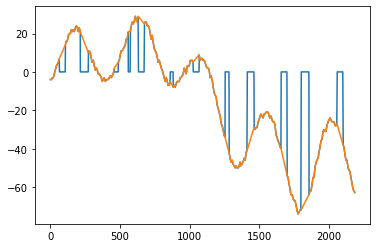

In [146]:
plt.plot(eclipse_data_interp*(1-s_t_days))
plt.plot(eclipse_data_interp)

[]

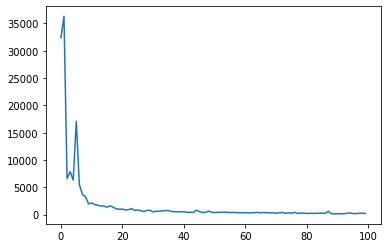

In [147]:
plt.plot(abs(fft(eclipse_data_interp)[0:100]))

plt.plot()

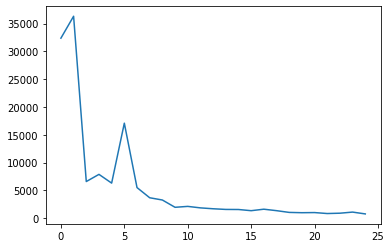

In [148]:
#plt.plot(np.abs(np.fft(s_t_days)[0:25]))
plt.plot(np.abs(fft(eclipse_data_interp)[0:25]))#plt.plot(np.abs(fft(eclipse_data_interp)[0:25]))#

/home/vserra/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


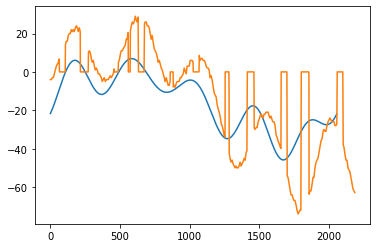

In [149]:
# try to build back the signal with the first 5 harmonics

signal_back = np.fft.ifft(fft(eclipse_data_interp)[0:7], 2056)#*(1-s_t_days)

plt.plot(signal_back)
plt.plot(eclipse_data_interp*(1-s_t_days))

In [150]:
print(peaks[0: int(len(peaks)/2)])

[  121   547   944  1179  1377  1575  1983  2217  2603  2814  3059  3288
  3725  3912  4159  4459  4829  5150  5427  5856  6246  6636  7189  7684
  8116  8599  8875  9138  9406  9647  9907 10199 10696 10924 11251 11665
 11958 12245 12487 12721 13056 13314 13577 14116 14354 14927 15470 15766
 16065 16332 16654 16886 17115 17369 17532 17783 18147 18398 19194 19445
 19736 20518 20743 21146 21552 21988 22183 22817 23053 23602 23921 24269
 24589 25174 25769 26005 26240 26898 27116 31326 32210 32441 32693 33283
 34190 34530 35389 35634 39003 40039 41059 42382 42684 44876 46489 46768
 47527 53301 55385 61517 63604]


In [151]:
#now let's comnpute the spectrum of the signal in days with a super-resolution

#at first we need to create more samples inbetween the values
#since we are expecting a periodicity of 11 years and of 1 year overlapped, they should not end up in the first
#frequency bin
#this way we are kind of inserting a lot more data-points in the curve and shifting the frequencies to the 

In [152]:

from scipy.optimize import curve_fit

def func(time, f_1, phi_1, amplitude_1, f_2, phi_2, amplitude_2, offset):

    return offset + amplitude_1*np.sin(f_1*2*np.pi*time/365 + phi_1) + amplitude_2*np.sin(f_2*2*np.pi*time/365 + phi_2)

In [153]:
print(np.size(s_t_days))


mask = (1-s_t_days)

print(np.size(s_t_days))

mask = np.array(mask, dtype = 'bool')

print(mask)

values_w_nan = np.zeros(len(eclipse_data_interp))

values_w_nan[(1-s_t_days)==0] = np.nan
values_w_nan[(1-s_t_days)!=0] = eclipse_data_interp[(1-s_t_days)!=0]

popt, pcov = curve_fit(func, days_linspace[mask], eclipse_data_interp[mask], maxfev=10**4, 
                       bounds=([0,0,0,0,0,0,-100],[1.7, 2*np.pi, 50,0.15,2*np.pi,200,+100]), 
                      )#sigma = (1-s_t_days)+0.00001)


print(*popt)


2185
2185
[ True  True  True ...  True  True  True]
0.7911500764540574 5.583820204666775 18.388856745446365 0.1320395316816586 0.42777115807114857 32.860297125922344 -17.392867258812757


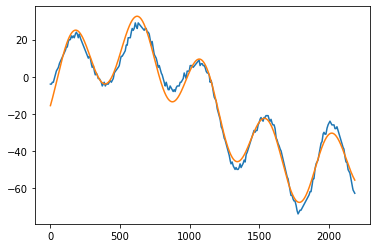

In [154]:
plt.plot(eclipse_data_interp[:])
plt.plot(func(days_linspace[:],*popt))

Text(0.5, 1.0, 'Variation in eclipse Time for satellite 2 - D')

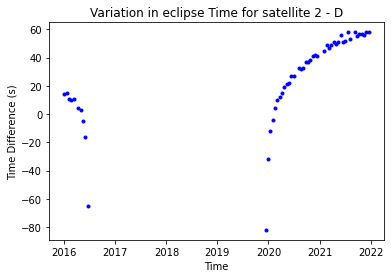

In [155]:
# create the dataframe from a query
df = pd.read_sql_query("SELECT * FROM Event", cnx)

sql_cmd = """

WITH

PyMeeus AS
(
SELECT DateTimeEventTT, Satellite || Type1 || Type2 || Type3 AS Type, DateTimeEventTT, 
Satellite, Type1, Type2, Type3
FROM Event
WHERE ((Origin="PyMeeus") 
AND (Satellite == 4)  
AND (Type1 = "EC")
AND (Type2 = "D") 
AND (Type3 = "INT")
)),

Thuillot AS
(
SELECT DateTimeEventTT, Satellite || Type1 || Type2 || Type3 AS Type, DateTimeEventTT
FROM Event
WHERE ((Origin="Thuillot") 
AND (Satellite == 4)  
AND (Type1 = "EC")
AND (Type2 = "D") 
AND (Type3 = "INT")
))


SELECT p.DateTimeEventTT, p.Satellite, p.Type1, p.Type2, p.Type3, 
strftime('%s', p.DateTimeEventTT) - strftime('%s', t.DateTimeEventTT) AS deltaTime, 
MIN( ABS( strftime('%s', p.DateTimeEventTT) - strftime('%s', t.DateTimeEventTT) )) AS minDeltaTime
FROM (PyMeeus p INNER JOIN Thuillot t
ON p.Type = t.Type)
GROUP BY p.DateTimeEventTT
HAVING minDeltaTime <= 3600

"""

df = pd.read_sql_query(sql_cmd, cnx)

#now do the same for europa --> load the data

df_EC_INT_IO_INT= df[((df.Satellite == 4)&(df.Type1 == 'EC')&(df.Type2 == 'D')&(df.Type3 == 'INT'))]

df_EC_INT_IO_INT= df_EC_INT_IO_INT[[ 'DateTimeEventTT','deltaTime']]

dates_int = matplotlib.dates.date2num(df_EC_INT_IO_INT['DateTimeEventTT'].to_numpy())
matplotlib.pyplot.plot_date(dates_int, df_EC_INT_IO_INT['deltaTime'].to_numpy(), 'b.')

plt.ylabel('Time Difference (s)')
plt.xlabel('Time')
plt.title('Variation in eclipse Time for satellite 2 - D')

In [156]:
datetime_array = df_EC_INT_IO_INT['DateTimeEventTT'].to_numpy()

In [157]:
df_unix_sec = pd.to_datetime(df_EC_INT_IO_INT['DateTimeEventTT']).astype(int)/ 10**9

#print(df_unix_sec)

first_sampling_time = df_unix_sec[0]

relative_sampling_time = df_unix_sec - first_sampling_time

print(relative_sampling_time)

0             0.0
1       1447263.0
2       2894562.0
3       4341956.0
4       5789368.0
5       8684468.0
6      10132122.0
7      11579884.0
8      13027838.0
9      14476153.0
10    124460789.0
11    125907309.0
12    127354064.0
13    128800968.0
14    130247884.0
15    131694850.0
16    133141882.0
17    134588911.0
18    136035970.0
19    137483119.0
20    138930271.0
21    140377473.0
22    141824787.0
23    144719530.0
24    146167034.0
25    147614572.0
26    149062134.0
27    150509781.0
28    151957419.0
29    153405073.0
30    154852759.0
31    156300432.0
32    160643435.0
33    162091083.0
34    163538753.0
35    164986390.0
36    166434036.0
37    167881705.0
38    169329370.0
39    170777048.0
40    172224783.0
41    173672527.0
42    175120328.0
43    176568194.0
44    179464094.0
45    180912150.0
46    182360246.0
47    183808390.0
48    185256574.0
49    186704772.0
50    188152999.0
Name: DateTimeEventTT, dtype: float64


In [ ]:
#now we must find samples that are more than three days apart, usually the orbital period is somewhat like 6 days, so everything is ok

samples_diff_vec = np.zeros(len(relative_sampling_time)-1)

for i in range (len(relative_sampling_time)-1):

    samples_diff_vec[i] = relative_sampling_time[i+1] - relative_sampling_time[i]

    
#print(samples_diff_vec)

hot_positions = samples_diff_vec > 3600*24*180 #six months

#print(hot_positions)

#identify positions limits for the s(t) function

s_limits = np.zeros(len(relative_sampling_time))


for i in range (len(hot_positions)):

    if(hot_positions[i]):
    
        s_limits[i] = relative_sampling_time[i]
        i = i+1
        s_limits[i] = relative_sampling_time[i]

#print(s_limits)

non_zero_indices = (np.nonzero(s_limits))[0]


print(non_zero_indices)

s_t = np.zeros(int(max(relative_sampling_time)))

i = 0

while i in range(np.size(non_zero_indices)-1):
    
    l_index = non_zero_indices[i]
    print(l_index)
    tmp = i+1
    i = i+1
    r_index = non_zero_indices[tmp]
    i = i+1

    print(r_index)
    
    print(int(relative_sampling_time[l_index]))
    print(int(relative_sampling_time[r_index]))
    print('---')
    
    for e in range(int(relative_sampling_time[l_index]), int(relative_sampling_time[r_index])):
        s_t[e] = 1.0
        #print(int(relative_sampling_time[l_index]))
        
        

#print(s_t)
 
print(np.sum(s_t))

s_t_sparse=sparse.csr_matrix(s_t)
    

[ 9 10]
9
10
14476153
124460789
---
109984636.0


In [ ]:
plt.plot(s_t[::32])

In [ ]:
s_jump_spectrum = fft(s_t[::32])


print(s_jump_spectrum)

In [ ]:
plt.plot(s_jump_spectrum[0:10**2])

In [ ]:
#now we have to generate the remianing data from the eclipse difference time data

eclipse_diff_data = np.zeros(int(max(relative_sampling_time)))


time_diff_data_sparse = df_EC_INT_IO_INT['deltaTime'].to_numpy()


for i in range(len(relative_sampling_time)-1):
    
    timestamp = int(relative_sampling_time[i])
    
    eclipse_diff_data[timestamp] = time_diff_data_sparse[i]

In [ ]:
plt.plot(eclipse_diff_data[::32], 'b.')

In [ ]:
#perform the FFT

#the frequencie we want to be able to see are 1y and 10y. The overall sampling time is 5 years, menaning that we
#need to at least extend the number of samples --> this is only possible by performing a downsampling first
#otherwise the vector will be too much for the memory of the machine

#we are measuring everything in seconds, we don't really need that precision, let's switch to hours instead,
#this will reduce the size of the data to 50 thousands points

n_samples_per_bin = 3600
binned_vec_len = int((len(eclipse_diff_data)/n_samples_per_bin))

print("Length of new vector : " + str(binned_vec_len) + " from : " + str(len(eclipse_diff_data)))

zeropad_initial = len(eclipse_diff_data) - n_samples_per_bin * binned_vec_len

zeropad_vec = np.zeros(zeropad_initial)

np.append(eclipse_diff_data, zeropad_vec)

binned_eclipse_data_hours = np.zeros(binned_vec_len)

for i in range(binned_vec_len):

    binned_eclipse_data_hours[i] = np.sum(eclipse_diff_data[i*n_samples_per_bin: (i+1)*n_samples_per_bin])

#eclipse_data_downsampled = eclipse_diff_data[::10]

#print(str(len(eclipse_data_downsampled))  + "samples, is a 5 years period")

#len_zero_trailer = int(len(eclipse_data_downsampled) * 6 / 5);

#zero_trailer = np.zeros(len_zero_trailer)

#np.append(eclipse_data_downsampled, zero_trailer)

#plt.plot(eclipse_data_downsampled)

#s_spectrum = fft(eclipse_diff_data)


#print(s_spectrum)

In [ ]:
plt.plot(binned_eclipse_data_hours, 'b.')

In [ ]:
s_spectrum = fft(binned_eclipse_data_hours)

In [ ]:
plt.plot(s_spectrum[:], 'b.')

In [ ]:
#this is not a particularry good result, there are too many variables variating the spectrum, 
#hence too many harmonics
#we should filter it before we proceed

In [ ]:
#let's begin with an interpolation, a simple cubic one

hours_linspace = np.linspace(0, len(binned_eclipse_data_hours)-1, len(binned_eclipse_data_hours))

idx = np.nonzero(binned_eclipse_data_hours)
interp = interp1d(hours_linspace[idx],binned_eclipse_data_hours[idx], kind = 'linear', fill_value="extrapolate")

print(interp)

eclipse_data_interp = interp(hours_linspace[:])

In [ ]:
plt.plot(eclipse_data_interp, 'b.')
plt.plot(binned_eclipse_data_hours, 'r.')

In [ ]:
#zero pad for higher resolutioin
zero_pad = np.zeros(10**7)
s_interp = fft(np.append(eclipse_data_interp, zero_pad))

In [ ]:
plt.plot(s_interp[0:4*10**2*10**1])

In [ ]:
peaks, _ = find_peaks(np.abs(s_interp[:]), height=10**4)


print(peaks)

In [ ]:
plt.plot(eclipse_data_interp[9000:11000], 'b.')

In [ ]:
plt.plot(ifft(np.append(s_interp[0:10**4], zero_pad))[0:50*10**3])



In [ ]:
np.append(s_t, zeropad_vec)

s_t_hrs = np.zeros(binned_vec_len)

print(binned_vec_len)

for i in range(binned_vec_len):

    s_t_hrs[i] = np.mean(s_t[i*n_samples_per_bin: (i+1)*n_samples_per_bin])

In [ ]:
plt.plot(s_t_hrs)

print(len(s_t_hrs))

print(len(eclipse_data_interp))

In [ ]:
cleaned_array = eclipse_data_interp * (1-s_t_hrs)

plt.plot(cleaned_array)

s_cleaned = fft(np.append(cleaned_array, zero_pad))

In [ ]:
plt.plot(s_cleaned[0:10**3])

In [ ]:
plt.plot(abs(s_cleaned[0:10**4]))

In [ ]:
peaks, _ = find_peaks(np.abs(s_cleaned[:]), height=10**4)


print(peaks)

In [ ]:
#filter out the HF components resulting from the effect of rounding off to 1 sec

In [ ]:
from scipy import signal


sos = signal.cheby1(10, 0.001, 0.005, 'low', analog=False, output = 'sos')

filtered = signal.sosfilt(sos, eclipse_data_interp*(1-s_t_hrs))

print(len(eclipse_data_interp))

plt.plot(filtered[9000:11000], 'b.')
plt.plot(eclipse_data_interp[9000:11000], 'r.')

In [ ]:
plt.plot(filtered[:], 'b.')
plt.plot(cleaned_array[:], 'r.')

In [ ]:
s_cleaned_cheby = fft(np.append(filtered, zero_pad))

plt.plot(s_cleaned_cheby[0:10**4])
plt.plot(s_cleaned[0:10**4])

In [ ]:
plt.plot(np.abs(s_cleaned_cheby[0:10**4]))
plt.plot(np.abs(s_cleaned[0:10**4]))

In [ ]:
fft_s_t_upsample = fft(np.append(1-s_t_hrs , zero_pad)) 

In [ ]:


plt.plot(np.abs(fft_s_t_upsample)[0:10**4])

In [ ]:
plt.plot(np.abs(fft_s_t_upsample)[0:10**4])
plt.plot(np.abs(s_cleaned_cheby[0:10**4]))
plt.plot(np.abs(s_cleaned[0:10**4]))

In [ ]:
#corr = np.correlate(s_cleaned_cheby, fft_s_t_upsample[0:10**4])


In [ ]:
#plt.plot(np.abs(corr[0:10**4]))

In [ ]:
plt.plot(np.abs(fft_s_t_upsample)[0:10**4])
plt.plot(np.abs(s_cleaned_cheby[0:10**4]))

In [ ]:
n_samples_per_bin = 3600*24
binned_vec_len = int((len(eclipse_diff_data)/n_samples_per_bin))

print("Length of new vector : " + str(binned_vec_len) + " from : " + str(len(eclipse_diff_data)))

zeropad_initial = len(eclipse_diff_data) - n_samples_per_bin * binned_vec_len

zeropad_vec = np.zeros(zeropad_initial)

np.append(eclipse_diff_data, zeropad_vec)

binned_eclipse_data_days = np.zeros(binned_vec_len)

for i in range(binned_vec_len):

    binned_eclipse_data_days[i] = np.sum(eclipse_diff_data[i*n_samples_per_bin: (i+1)*n_samples_per_bin])
    

days_linspace = np.linspace(0, len(binned_eclipse_data_days)-1, len(binned_eclipse_data_days))

idx = np.nonzero(binned_eclipse_data_days)
interp = interp1d(hours_linspace[idx],binned_eclipse_data_days[idx], kind = 'linear', fill_value="extrapolate")

print(interp)

eclipse_data_interp = interp(days_linspace[:])

plt.plot(eclipse_data_interp)

In [ ]:
s_t_days = np.zeros(binned_vec_len)

print(binned_vec_len)

for i in range(binned_vec_len):

    s_t_days[i] = np.mean(s_t[i*n_samples_per_bin: (i+1)*n_samples_per_bin])

In [ ]:
plt.plot(eclipse_data_interp*(1-s_t_days))
plt.plot(eclipse_data_interp)

In [ ]:
plt.plot(abs(fft(eclipse_data_interp)[0:100]))

plt.plot()

In [ ]:
#plt.plot(np.abs(np.fft(s_t_days)[0:25]))
plt.plot(np.abs(fft(eclipse_data_interp)[0:25]))#plt.plot(np.abs(fft(eclipse_data_interp)[0:25]))#

In [ ]:
# try to build back the signal with the first 5 harmonics

signal_back = np.fft.ifft(fft(eclipse_data_interp)[0:7], 2056)#*(1-s_t_days)

plt.plot(2*signal_back-5)
plt.plot(eclipse_data_interp*(1-s_t_days))

In [ ]:
print(peaks[0: int(len(peaks)/2)])

In [ ]:
#now let's comnpute the spectrum of the signal in days with a super-resolution

#at first we need to create more samples inbetween the values
#since we are expecting a periodicity of 11 years and of 1 year overlapped, they should not end up in the first
#frequency bin
#this way we are kind of inserting a lot more data-points in the curve and shifting the frequencies to the 

In [ ]:

from scipy.optimize import curve_fit

def func(time, f_1, phi_1, amplitude_1, f_2, phi_2, amplitude_2, offset):

    return offset + amplitude_1*np.sin(f_1*2*np.pi*time/365 + phi_1) + amplitude_2*np.sin(f_2*2*np.pi*time/365 + phi_2)

In [ ]:
print(np.size(s_t_days))


mask = (1-s_t_days)

print(np.size(s_t_days))

mask = np.array(mask, dtype = 'bool')

print(mask)

values_w_nan = np.zeros(len(eclipse_data_interp))

values_w_nan[(1-s_t_days)==0] = np.nan
values_w_nan[(1-s_t_days)!=0] = eclipse_data_interp[(1-s_t_days)!=0]

popt, pcov = curve_fit(func, days_linspace[mask], eclipse_data_interp[mask], maxfev=10**4, 
                       bounds=([0,0,0,0,0,0,-7],[2, 2*np.pi, 100,0.2,2*np.pi,100,+10]), 
                      )#sigma = (1-s_t_days)+0.00001)


print(*popt)


In [ ]:
plt.plot(eclipse_data_interp[:])
plt.plot(func(days_linspace[:],*popt))

In [ ]:
len(peaks)

In [ ]:
#one year in seconds

y_in_sec = 3600*24*365.25
print(y_in_sec)

In [ ]:
print(max(relative_sampling_time))

In [ ]:
max(relative_sampling_time) / 5


In [ ]:
y_in_sec / 5

In [ ]:
y_in_sec / (5*5)

In [ ]:
#the frequency will be measured in JULIAN years, hence let's begin with a test of that and then move on
#to the real fft of the data

#the samples are taken at 1 sec distance from one another

#inteval_length_sec = max(relative_sampling_time) #length of the sampling interval in seconds

#t_vec_sec = np.linspace(0,int(inteval_length_sec), int(inteval_length_sec)+1) 

#convert the interval to JULIAN years
#y_in_sec = 31557600

#test it all with a sine function
#freq_test = 1 #years
#y_test = np.sin(freq_test * 2 * np.pi * t_vec_sec / y_in_sec ) + np.sin(freq_test * 5 * 2 * np.pi * t_vec_sec / y_in_sec )



In [ ]:
#downsample fft
#downsample_analysis = 4

#perform the fft
#spectrum_test = np.fft.fft(eclipse_diff_data[::downsample_analysis])

#N = s_spectrum.size #number of samples
#T = 1/y_in_sec  #spacing between samples

#freq = np.linspace(0,T,N)

#downsample_visualizatioin = 16

#plt.plot(freq[::downsample_visualizatioin*downsample_analysis], spectrum_test[::downsample_visualizatioin])

#plt.plot(spectrum_test[::downsample_visualizatioin])

In [ ]:
#import plotly.express as px
#import plotly.graph_objects as go

#fig = go.Figure(data=go.Scatter(y=np.abs(s_spectrum[::downsample_visualizatioin])))
#fig.show()

In [ ]:
#plt.plot(y_test[::16])

In [ ]:
#plt.plot(abs(spectrum_test[0:40]), '.')

In [ ]:
x = np.linspace(0, 5000, num = 1000)

y = np.sin(1*2*np.pi*x/1000) + np.sin(0.1*2*np.pi*x/1000)
#y = y + +np.sin(1/50*x)

In [ ]:
spt = fft(np.append(y, np.zeros(19000)), 20000)

T = 1  # sampling interval 
N = y.size

# 1/T = frequency
f = np.linspace(0, 1 / T, N)

plt.plot(y)

In [ ]:
plt.plot(np.abs(spt[0:200]), 'b')

print(len(spt))

In [ ]:
x = np.linspace(0, 7000, num = 8000)

#y = np.sin(1*2*np.pi*x/1000) + 

y = np.sin(0.1*2*np.pi*x/1000)

y = signal.resample(y, int(len(x)/2))

print(y)

print(len(y))

In [ ]:
spt = fft(np.append(y, np.zeros(20000)), len(y)+20000)

T = 1  # sampling interval 
N = y.size

# 1/T = frequency
f = np.linspace(0, 1 / T, N)

plt.plot(y)

In [ ]:
plt.plot(np.abs(spt[0:100]), 'b')

print(len(spt))